import numpy as np
# ^^^ pyforest auto-imports - don't write above this line
# Implementing a Neural Network
This exercise is taken from Stanford's CS231N course.  

In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [27]:
# A bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
!sh cs231n/datasets/get_datasets.sh

--2020-03-15 22:38:53--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar   0%[                    ]   1.31M  77.0KB/s    eta 19m 17s^C


## The CIFAR dataset

In [3]:
# Load the raw CIFAR-10 data.
import random
from cs231n.data_utils import load_CIFAR10
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


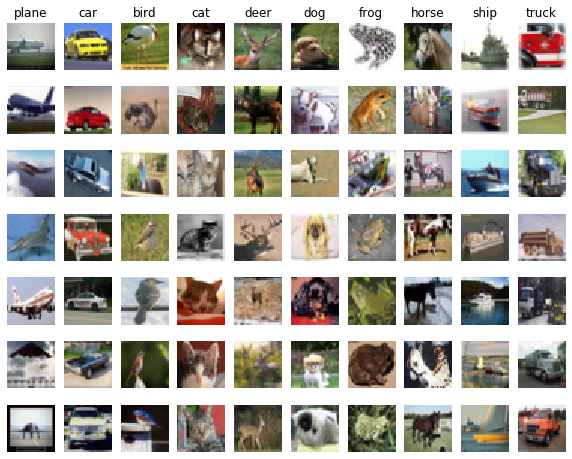

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


## A 2-layer Neural Network

We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [7]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [8]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [9]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.01896541960606335


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [10]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)
print(loss, grads)
# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

1.2848224717239367 {'W1': array([[-1.05670166e-01,  2.00078604e-03, -2.10411518e-01,
         1.76781886e-01,  1.51193855e-01, -4.88638940e-03,
         4.75044209e-03,  3.44562949e-03, -2.95861868e-02,
        -7.73102052e-03],
       [ 4.38392829e-02,  7.27136753e-03,  6.91710314e-01,
        -2.89224702e-01, -2.69206305e-01,  1.66837164e-03,
         7.47039537e-03,  2.03693499e-02, -6.70354382e-02,
        -5.28658172e-01],
       [ 2.44627312e-02,  3.26809298e-03, -2.35945731e-01,
        -5.89282104e-02, -1.27651628e-02, -7.27182837e-03,
         2.28792587e-04, -1.96475152e-03,  5.28004133e-01,
         3.62385204e-01],
       [ 7.64019031e-02,  1.89081260e-03, -3.09339394e-01,
         2.36772550e-01,  2.08418270e-01,  7.81744846e-04,
         6.15145340e-03, -8.19245710e-03, -6.77006406e-01,
         1.00068815e-01]]), 'W2': array([[-5.08521926e-01,  1.74333019e-01,  3.13314701e-01],
       [ 9.75387698e-03, -2.54826091e-03, -2.19037151e-03],
       [ 2.98493150e-01,  1.150094

# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

iteration 0 / 100: loss 1.241992
Final training loss:  0.01714364353292381


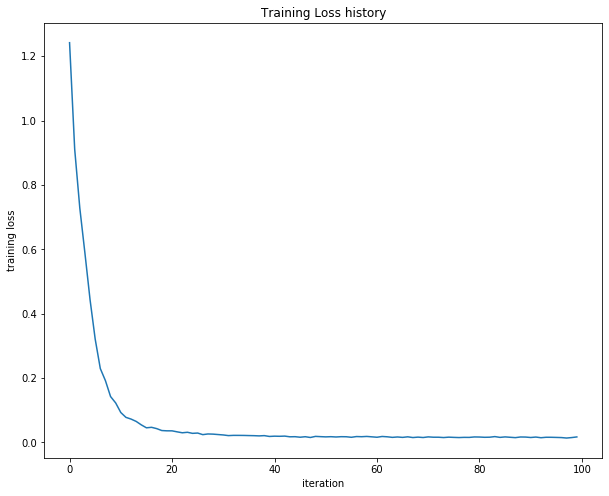

In [11]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=True)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [12]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [13]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)



iteration 0 / 1000: loss 2.302762
iteration 100 / 1000: loss 2.302358
iteration 200 / 1000: loss 2.297404
iteration 300 / 1000: loss 2.258897
iteration 400 / 1000: loss 2.202975
iteration 500 / 1000: loss 2.116816
iteration 600 / 1000: loss 2.049789
iteration 700 / 1000: loss 1.985711
iteration 800 / 1000: loss 2.003726
iteration 900 / 1000: loss 1.948076
Validation accuracy:  0.287


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

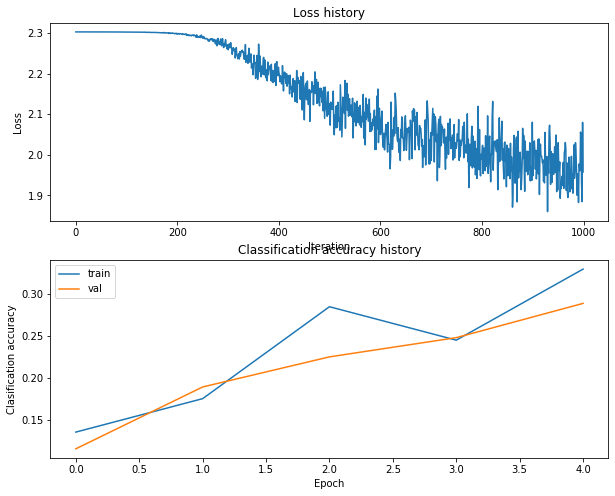

In [14]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

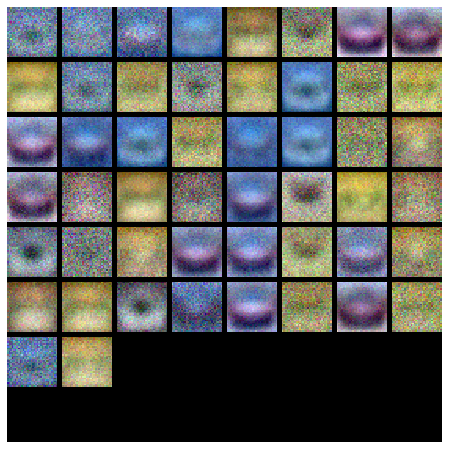

In [15]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [16]:
import itertools

In [22]:
best_net = None # store the best model into this 
best_acc = 0
best_params = None
best_stats = None
#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
input_size = 32 * 32 * 3
num_classes = 10

grid_search_params = dict(hidden_size=[150, 175], num_iters=[1000, 2000],
                          learning_rate=[5e-3, 2.5e-3], reg=[0.10, 0.15, 0.20],
                          learning_rate_decay=[0.85, 0.9, 0.95], 
                          batch_size=[500, 1000]
                         )

comb = 1
for x in grid_search_params.values():
    comb *= len(x)
    
print(f'There are {comb} combinations of hyperparameters')

keys, values = zip(*grid_search_params.items())

for v in itertools.product(*values):
    h_params = dict(zip(keys, v))
    print(h_params)

                
    net = TwoLayerNet(input_size, h_params['hidden_size'], num_classes)

# Train the network
    stats = net.train(X_train, y_train, X_val, y_val, verbose=True,
                      num_iters=h_params['num_iters'], batch_size=h_params['batch_size'],
                      learning_rate=h_params['learning_rate'], 
                      learning_rate_decay=h_params['learning_rate_decay'],
                      reg=h_params['reg'], )

# Predict on the validation set
    val_acc = (net.predict(X_val) == y_val).mean()
    if val_acc > best_acc:
        best_acc = val_acc
        best_net = net
        best_params = h_params
        best_stats = stats
    print('Validation accuracy: ', val_acc)


#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

There are 144 combinations of hyperparameters
{'hidden_size': 150, 'num_iters': 1000, 'learning_rate': 0.005, 'reg': 0.1, 'learning_rate_decay': 0.85, 'batch_size': 500}
iteration 0 / 1000: loss 2.302819
iteration 100 / 1000: loss 3.405237
Validation accuracy:  0.097
{'hidden_size': 150, 'num_iters': 1000, 'learning_rate': 0.005, 'reg': 0.1, 'learning_rate_decay': 0.85, 'batch_size': 1000}
iteration 0 / 1000: loss 2.302793
iteration 100 / 1000: loss 1.635666
iteration 200 / 1000: loss 1.548557
iteration 300 / 1000: loss 1.402686
iteration 400 / 1000: loss 1.389467
iteration 500 / 1000: loss 1.326653
iteration 600 / 1000: loss 1.295788
iteration 700 / 1000: loss 1.334916
iteration 800 / 1000: loss 1.280538
iteration 900 / 1000: loss 1.264838
Validation accuracy:  0.523
{'hidden_size': 150, 'num_iters': 1000, 'learning_rate': 0.005, 'reg': 0.1, 'learning_rate_decay': 0.9, 'batch_size': 500}
iteration 0 / 1000: loss 2.302811
iteration 100 / 1000: loss 5.732347
Validation accuracy:  0.157


iteration 900 / 1000: loss 1.291125
Validation accuracy:  0.492
{'hidden_size': 150, 'num_iters': 1000, 'learning_rate': 0.0025, 'reg': 0.1, 'learning_rate_decay': 0.85, 'batch_size': 1000}
iteration 0 / 1000: loss 2.302836
iteration 100 / 1000: loss 1.752463
iteration 200 / 1000: loss 1.554696
iteration 300 / 1000: loss 1.517736
iteration 400 / 1000: loss 1.528132
iteration 500 / 1000: loss 1.492402
iteration 600 / 1000: loss 1.424237
iteration 700 / 1000: loss 1.424347
iteration 800 / 1000: loss 1.453957
iteration 900 / 1000: loss 1.462640
Validation accuracy:  0.48
{'hidden_size': 150, 'num_iters': 1000, 'learning_rate': 0.0025, 'reg': 0.1, 'learning_rate_decay': 0.9, 'batch_size': 500}
iteration 0 / 1000: loss 2.302799
iteration 100 / 1000: loss 1.675289
iteration 200 / 1000: loss 1.613688
iteration 300 / 1000: loss 1.573025
iteration 400 / 1000: loss 1.440474
iteration 500 / 1000: loss 1.480590
iteration 600 / 1000: loss 1.256315
iteration 700 / 1000: loss 1.406447
iteration 800 /

Validation accuracy:  0.486
{'hidden_size': 150, 'num_iters': 1000, 'learning_rate': 0.0025, 'reg': 0.2, 'learning_rate_decay': 0.95, 'batch_size': 1000}
iteration 0 / 1000: loss 2.303042
iteration 100 / 1000: loss 1.688883
iteration 200 / 1000: loss 1.596318
iteration 300 / 1000: loss 1.541641
iteration 400 / 1000: loss 1.464310
iteration 500 / 1000: loss 1.453065
iteration 600 / 1000: loss 1.387361
iteration 700 / 1000: loss 1.375902
iteration 800 / 1000: loss 1.308093
iteration 900 / 1000: loss 1.250075
Validation accuracy:  0.518
{'hidden_size': 150, 'num_iters': 2000, 'learning_rate': 0.005, 'reg': 0.1, 'learning_rate_decay': 0.85, 'batch_size': 500}
iteration 0 / 2000: loss 2.302841
iteration 100 / 2000: loss 1.823621
iteration 200 / 2000: loss 1.594665
iteration 300 / 2000: loss 1.535197
iteration 400 / 2000: loss 1.468002
iteration 500 / 2000: loss 1.366926
iteration 600 / 2000: loss 1.282368
iteration 700 / 2000: loss 1.210715
iteration 800 / 2000: loss 1.228322
iteration 900 

iteration 100 / 2000: loss 1.872606
iteration 200 / 2000: loss 1.656537
iteration 300 / 2000: loss 1.853858
iteration 400 / 2000: loss 1.578623
iteration 500 / 2000: loss 1.380472
iteration 600 / 2000: loss 1.477838
iteration 700 / 2000: loss 1.365277
iteration 800 / 2000: loss 1.355855
iteration 900 / 2000: loss 1.395728
iteration 1000 / 2000: loss 1.203732
iteration 1100 / 2000: loss 1.187218
iteration 1200 / 2000: loss 1.302028
iteration 1300 / 2000: loss 1.235584
iteration 1400 / 2000: loss 1.156541
iteration 1500 / 2000: loss 1.097081
iteration 1600 / 2000: loss 1.109419
iteration 1700 / 2000: loss 1.083596
iteration 1800 / 2000: loss 1.028200
iteration 1900 / 2000: loss 1.024526
Validation accuracy:  0.554
{'hidden_size': 150, 'num_iters': 2000, 'learning_rate': 0.005, 'reg': 0.2, 'learning_rate_decay': 0.85, 'batch_size': 500}
iteration 0 / 2000: loss 2.303055
iteration 100 / 2000: loss 2.091793
iteration 200 / 2000: loss 1.579447
iteration 300 / 2000: loss 1.544547
iteration 40

iteration 400 / 2000: loss 1.443687
iteration 500 / 2000: loss 1.444880
iteration 600 / 2000: loss 1.349918
iteration 700 / 2000: loss 1.375280
iteration 800 / 2000: loss 1.342263
iteration 900 / 2000: loss 1.325579
iteration 1000 / 2000: loss 1.246708
iteration 1100 / 2000: loss 1.344232
iteration 1200 / 2000: loss 1.302092
iteration 1300 / 2000: loss 1.316248
iteration 1400 / 2000: loss 1.296088
iteration 1500 / 2000: loss 1.270911
iteration 1600 / 2000: loss 1.263239
iteration 1700 / 2000: loss 1.264412
iteration 1800 / 2000: loss 1.266576
iteration 1900 / 2000: loss 1.252808
Validation accuracy:  0.524
{'hidden_size': 150, 'num_iters': 2000, 'learning_rate': 0.0025, 'reg': 0.1, 'learning_rate_decay': 0.95, 'batch_size': 500}
iteration 0 / 2000: loss 2.302807
iteration 100 / 2000: loss 1.704087
iteration 200 / 2000: loss 1.546567
iteration 300 / 2000: loss 1.510600
iteration 400 / 2000: loss 1.436143
iteration 500 / 2000: loss 1.385193
iteration 600 / 2000: loss 1.247063
iteration 7

iteration 1200 / 2000: loss 1.239006
iteration 1300 / 2000: loss 1.375038
iteration 1400 / 2000: loss 1.321435
iteration 1500 / 2000: loss 1.311111
iteration 1600 / 2000: loss 1.246465
iteration 1700 / 2000: loss 1.256428
iteration 1800 / 2000: loss 1.343657
iteration 1900 / 2000: loss 1.267607
Validation accuracy:  0.536
{'hidden_size': 150, 'num_iters': 2000, 'learning_rate': 0.0025, 'reg': 0.2, 'learning_rate_decay': 0.85, 'batch_size': 1000}
iteration 0 / 2000: loss 2.303024
iteration 100 / 2000: loss 1.704731
iteration 200 / 2000: loss 1.624641
iteration 300 / 2000: loss 1.518078
iteration 400 / 2000: loss 1.491034
iteration 500 / 2000: loss 1.467851
iteration 600 / 2000: loss 1.499345
iteration 700 / 2000: loss 1.430145
iteration 800 / 2000: loss 1.435577
iteration 900 / 2000: loss 1.391459
iteration 1000 / 2000: loss 1.425687
iteration 1100 / 2000: loss 1.376882
iteration 1200 / 2000: loss 1.420366
iteration 1300 / 2000: loss 1.403211
iteration 1400 / 2000: loss 1.413142
iterati

iteration 300 / 1000: loss 1.457577
iteration 400 / 1000: loss 1.356800
iteration 500 / 1000: loss 1.308851
iteration 600 / 1000: loss 1.299270
iteration 700 / 1000: loss 1.249486
iteration 800 / 1000: loss 1.354192
iteration 900 / 1000: loss 1.316320
Validation accuracy:  0.526
{'hidden_size': 175, 'num_iters': 1000, 'learning_rate': 0.005, 'reg': 0.15, 'learning_rate_decay': 0.9, 'batch_size': 500}
iteration 0 / 1000: loss 2.302995
iteration 100 / 1000: loss 2.196981
iteration 200 / 1000: loss 1.673080
iteration 300 / 1000: loss 1.554103
iteration 400 / 1000: loss 1.488132
iteration 500 / 1000: loss 1.420502
iteration 600 / 1000: loss 1.453927
iteration 700 / 1000: loss 1.283664
iteration 800 / 1000: loss 1.320806
iteration 900 / 1000: loss 1.364518
Validation accuracy:  0.501
{'hidden_size': 175, 'num_iters': 1000, 'learning_rate': 0.005, 'reg': 0.15, 'learning_rate_decay': 0.9, 'batch_size': 1000}
iteration 0 / 1000: loss 2.302988
iteration 100 / 1000: loss 1.908803
iteration 200 /

iteration 100 / 1000: loss 1.746994
iteration 200 / 1000: loss 1.654387
iteration 300 / 1000: loss 1.556083
iteration 400 / 1000: loss 1.465068
iteration 500 / 1000: loss 1.440804
iteration 600 / 1000: loss 1.461041
iteration 700 / 1000: loss 1.481854
iteration 800 / 1000: loss 1.406037
iteration 900 / 1000: loss 1.357501
Validation accuracy:  0.48
{'hidden_size': 175, 'num_iters': 1000, 'learning_rate': 0.0025, 'reg': 0.15, 'learning_rate_decay': 0.9, 'batch_size': 500}
iteration 0 / 1000: loss 2.302955
iteration 100 / 1000: loss 1.816300
iteration 200 / 1000: loss 1.661469
iteration 300 / 1000: loss 1.471661
iteration 400 / 1000: loss 1.443963
iteration 500 / 1000: loss 1.430211
iteration 600 / 1000: loss 1.356670
iteration 700 / 1000: loss 1.373716
iteration 800 / 1000: loss 1.269486
iteration 900 / 1000: loss 1.386360
Validation accuracy:  0.52
{'hidden_size': 175, 'num_iters': 1000, 'learning_rate': 0.0025, 'reg': 0.15, 'learning_rate_decay': 0.9, 'batch_size': 1000}
iteration 0 /

iteration 1900 / 2000: loss 1.136656
Validation accuracy:  0.546
{'hidden_size': 175, 'num_iters': 2000, 'learning_rate': 0.005, 'reg': 0.1, 'learning_rate_decay': 0.95, 'batch_size': 500}
iteration 0 / 2000: loss 2.302887
Validation accuracy:  0.143
{'hidden_size': 175, 'num_iters': 2000, 'learning_rate': 0.005, 'reg': 0.1, 'learning_rate_decay': 0.95, 'batch_size': 1000}
iteration 0 / 2000: loss 2.302846
iteration 100 / 2000: loss 3.149022
Validation accuracy:  0.147
{'hidden_size': 175, 'num_iters': 2000, 'learning_rate': 0.005, 'reg': 0.15, 'learning_rate_decay': 0.85, 'batch_size': 500}
iteration 0 / 2000: loss 2.302997
iteration 100 / 2000: loss 1.831145
iteration 200 / 2000: loss 1.700538
iteration 300 / 2000: loss 1.517271
iteration 400 / 2000: loss 1.402336
iteration 500 / 2000: loss 1.399939
iteration 600 / 2000: loss 1.389929
iteration 700 / 2000: loss 1.269549
iteration 800 / 2000: loss 1.296028
iteration 900 / 2000: loss 1.243973
iteration 1000 / 2000: loss 1.224375
iterat

iteration 1100 / 2000: loss 1.195943
iteration 1200 / 2000: loss 1.161608
iteration 1300 / 2000: loss 1.184846
iteration 1400 / 2000: loss 1.213393
iteration 1500 / 2000: loss 1.164617
iteration 1600 / 2000: loss 1.141196
iteration 1700 / 2000: loss 1.190944
iteration 1800 / 2000: loss 1.137881
iteration 1900 / 2000: loss 1.161135
Validation accuracy:  0.548
{'hidden_size': 175, 'num_iters': 2000, 'learning_rate': 0.005, 'reg': 0.2, 'learning_rate_decay': 0.95, 'batch_size': 500}
iteration 0 / 2000: loss 2.303126
Validation accuracy:  0.111
{'hidden_size': 175, 'num_iters': 2000, 'learning_rate': 0.005, 'reg': 0.2, 'learning_rate_decay': 0.95, 'batch_size': 1000}
iteration 0 / 2000: loss 2.303141
iteration 100 / 2000: loss 1.702552
Validation accuracy:  0.069
{'hidden_size': 175, 'num_iters': 2000, 'learning_rate': 0.0025, 'reg': 0.1, 'learning_rate_decay': 0.85, 'batch_size': 500}
iteration 0 / 2000: loss 2.302870
iteration 100 / 2000: loss 1.740798
iteration 200 / 2000: loss 1.625738

iteration 700 / 2000: loss 1.335419
iteration 800 / 2000: loss 1.313682
iteration 900 / 2000: loss 1.328900
iteration 1000 / 2000: loss 1.246320
iteration 1100 / 2000: loss 1.191349
iteration 1200 / 2000: loss 1.249823
iteration 1300 / 2000: loss 1.315630
iteration 1400 / 2000: loss 1.262069
iteration 1500 / 2000: loss 1.172874
iteration 1600 / 2000: loss 1.235168
iteration 1700 / 2000: loss 1.179682
iteration 1800 / 2000: loss 1.165713
iteration 1900 / 2000: loss 1.089747
Validation accuracy:  0.544
{'hidden_size': 175, 'num_iters': 2000, 'learning_rate': 0.0025, 'reg': 0.15, 'learning_rate_decay': 0.9, 'batch_size': 1000}
iteration 0 / 2000: loss 2.302979
iteration 100 / 2000: loss 1.703856
iteration 200 / 2000: loss 1.584156
iteration 300 / 2000: loss 1.482963
iteration 400 / 2000: loss 1.455921
iteration 500 / 2000: loss 1.426805
iteration 600 / 2000: loss 1.404504
iteration 700 / 2000: loss 1.397157
iteration 800 / 2000: loss 1.321391
iteration 900 / 2000: loss 1.340915
iteration 

iteration 1500 / 2000: loss 1.185090
iteration 1600 / 2000: loss 1.138974
iteration 1700 / 2000: loss 1.130587
iteration 1800 / 2000: loss 1.147577
iteration 1900 / 2000: loss 1.160169
Validation accuracy:  0.55


In [23]:
print(f'Best Validation Accuracy: {best_acc}')

Best Validation Accuracy: 0.564


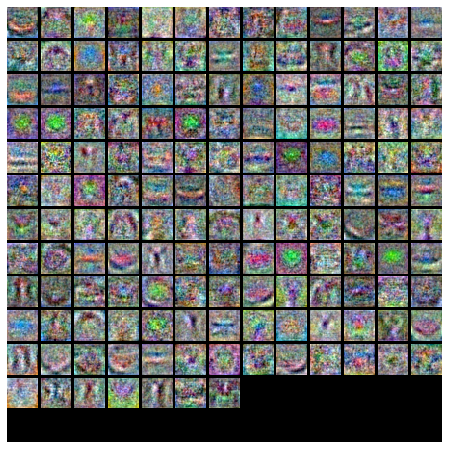

In [24]:
# visualize the weights of the best network
show_net_weights(best_net)

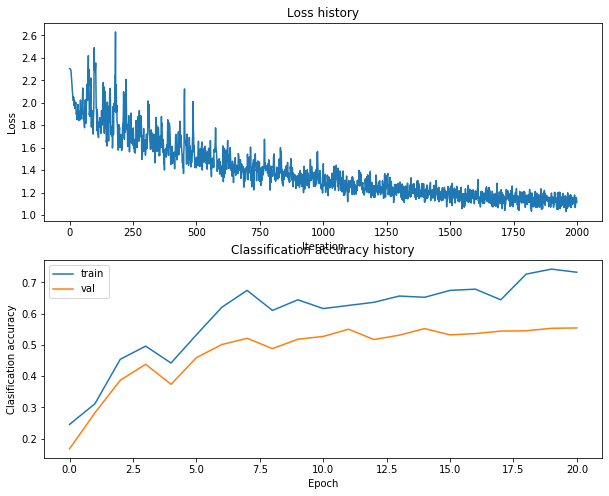

In [25]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [26]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.54


**Inline Question**

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

*Your answer*:

1 & 3 are good options to decrease the gap. 

*Your explanation:*

The testing accuracy being much lower than the training accuracy is an indication of overfitting. Training on a larger dataset is a good way of reducing overfitting, since it means the network is trained on more examples. Increasing the regularization parameter is also a good way to reduce overfitting since it reduces the complexity of the network by constraining the size of the weights and thereby the sensitivity of the network.